In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

plt.rcParams["font.family"] = "Times New Roman"

In [279]:
file = "Einstein_A_Good.xlsx"

cols1 = [["I_80", "F_80"], ["I_90","F_90"],["I_100_0","F_100_0"], ["I_110","F_110"], ["I_120","F_120"],["I_100_1","F_100_1"],["I_130","F_130"]]
cols2 = [["I_100_1","F_100_1"],["I_130","F_130"]]
cols = cols1
bins = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100])

df = pd.read_excel(file)

# Model
def Amplitude_model(x,A0,T):
    omega = 2* np.pi*x
    return((A0*T)/np.sqrt(1+(omega**2)*(T**2)))

p0_Amplitude_model = [0.01, 0.003]

bounds_Amplitude_model = (
    [0, 0],  # Lower bounds
    [np.inf, np.inf]  # Upper bounds
)



def arrhenius_model(T, C, Ea_eV, T0):
    k = 8.617e-5  # eV/K
    return T0/(1 + C*np.exp(-Ea_eV/(k*T)))

p0_arrhenius_model = [10, 0.1, 0.009]
bounds_arrhenius_model = (
    [0, 0, 0],
    [100, 1, 0.02]
)

def model_uncertainty(x, pop, cov):

    A0, T = pop
    omega = 2*np.pi*x
    denom = np.sqrt(1 + (omega**2)*(T**2))

    dA0 = T / denom
    dT  = A0 / (1 + (omega**2)*(T**2))**(3/2)

    var = (
        dA0**2 * cov[0,0] +
        dT**2  * cov[1,1] +
        2*dA0*dT*cov[0,1]
    )

    return np.sqrt(var)

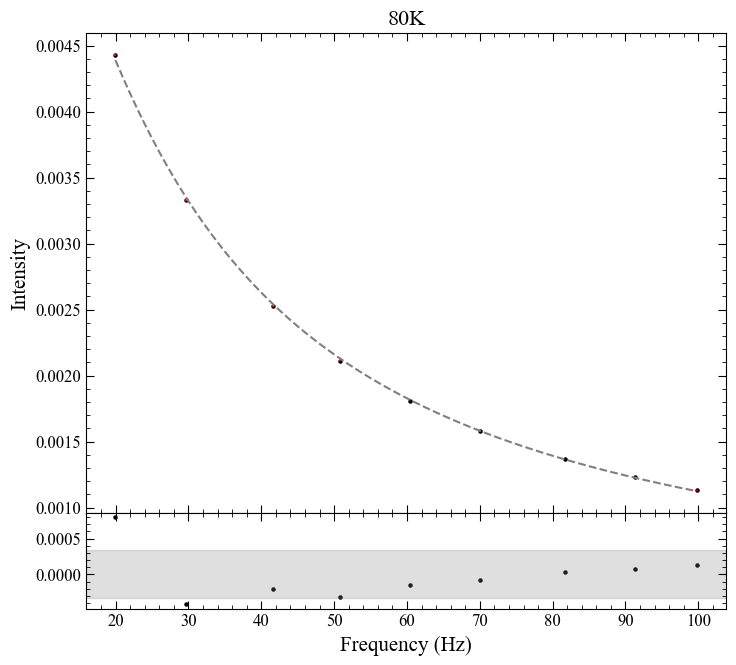

80K time const: 0.00964 time err: 0.00004
80K A0: 0.71483 A0_err: 0.00033


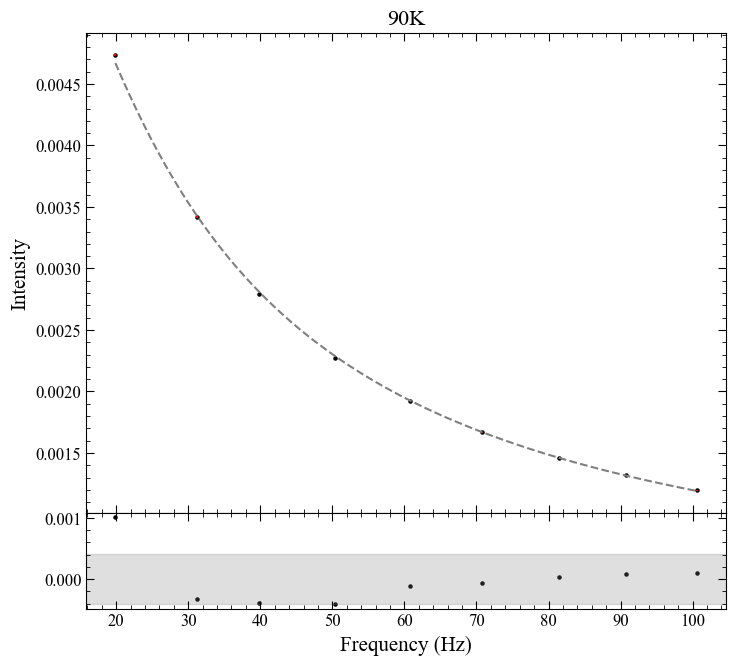

90K time const: 0.00950 time err: 0.00004
90K A0: 0.76289 A0_err: 0.00031


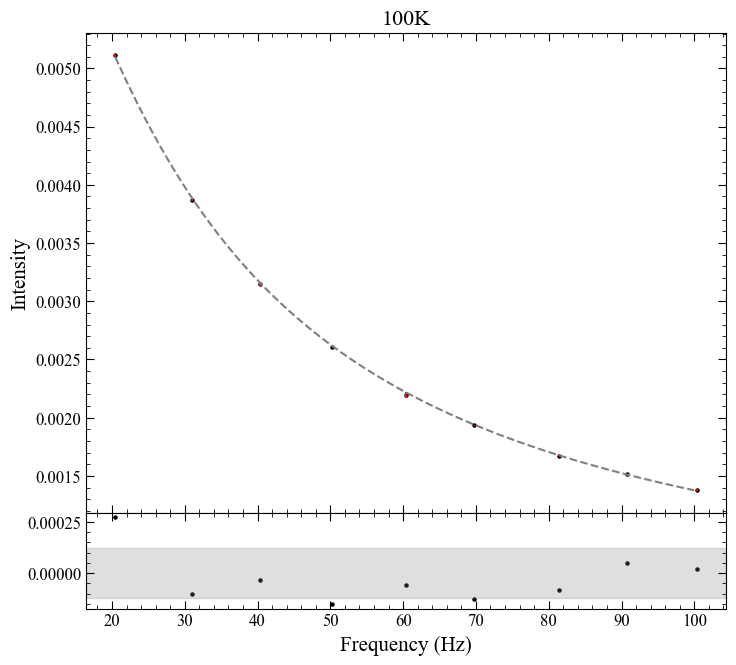

100K time const: 0.00870 time err: 0.00004
100K A0: 0.87927 A0_err: 0.00064


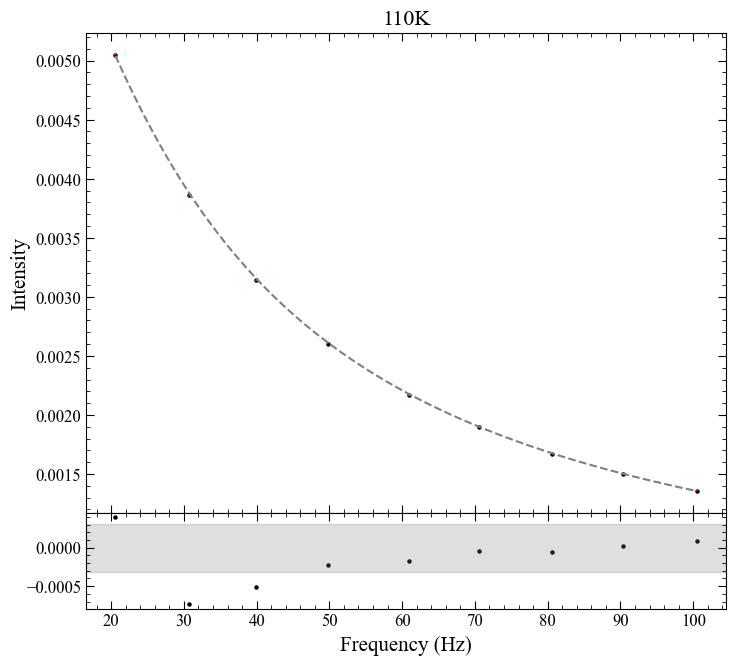

110K time const: 0.00876 time err: 0.00002
110K A0: 0.87004 A0_err: 0.00040


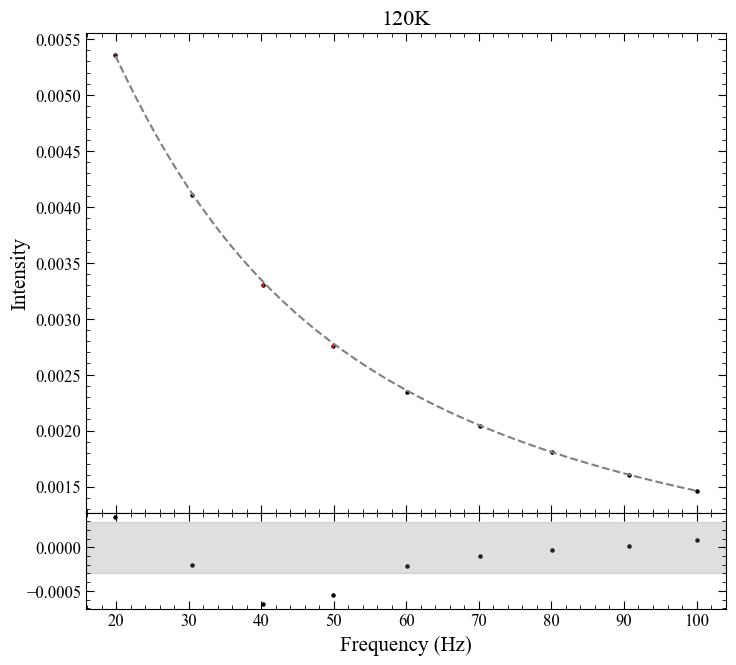

120K time const: 0.00818 time err: 0.00001
120K A0: 0.93576 A0_err: 0.00028


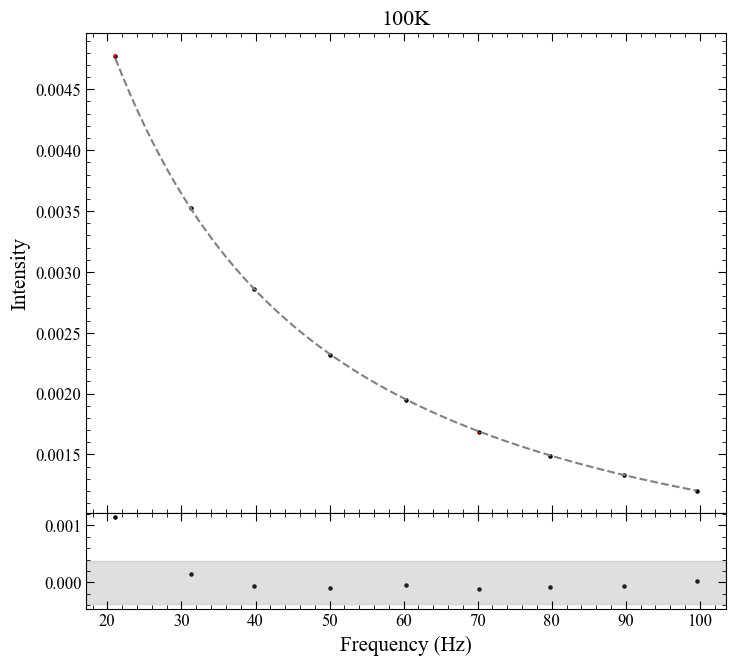

100K time const: 0.01115 time err: 0.00007
100K A0: 0.76001 A0_err: 0.00028


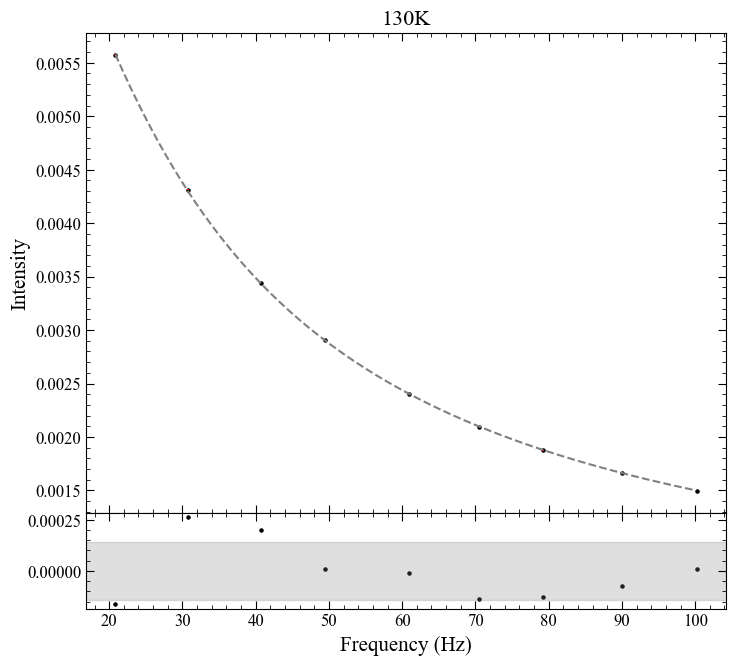

130K time const: 0.00900 time err: 0.00001
130K A0: 0.95821 A0_err: 0.00032


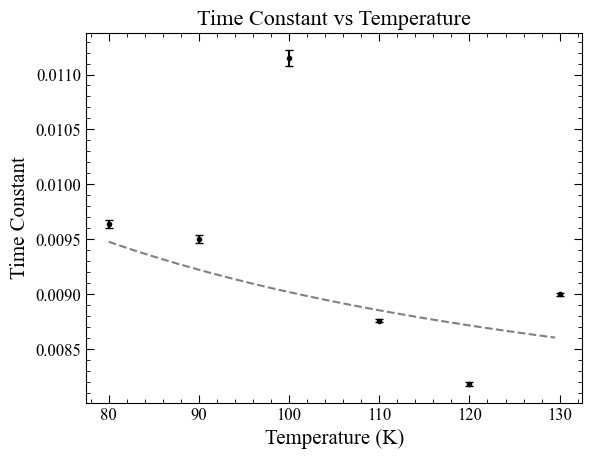

Estimated t_0 at 0 kelvin is 0.02000 s
Estimated A at 0 kelvin is 50.00000 1/s


In [280]:
# Dictionary to store results by temperature
results = {}

for I_col, F_col in cols:

    # Extract temperature from column name
    temp = I_col.split("_")[1] + "K"

    xdata = df[F_col].to_numpy()
    ydata = df[I_col].to_numpy()

    freq_values = []
    freq_uncertainty = []

    int_values = []
    int_uncertainty = []

    # Bin averaging
    for b in bins:

        mask = (xdata > b - 2) & (xdata < b + 2)

        frequency = xdata[mask]
        intensity = ydata[mask]

        if len(frequency) == 0:
            continue

        mean_freq = np.mean(frequency)
        err_freq = np.std(frequency) / np.sqrt(len(frequency))

        mean_intensity = np.mean(intensity)
        err_intensity = np.std(intensity) / np.sqrt(len(intensity))

        freq_values.append(mean_freq)
        freq_uncertainty.append(err_freq)

        int_values.append(mean_intensity)
        int_uncertainty.append(err_intensity)

    freq_values = np.array(freq_values)
    freq_uncertainty = np.array(freq_uncertainty)
    int_values = np.array(int_values)
    int_uncertainty = np.array(int_uncertainty)

    # Fit amplitude model
    pop_amp, cov_amp = curve_fit(
        Amplitude_model,
        freq_values,
        int_values,
        sigma=int_uncertainty,
        absolute_sigma=True,
        p0=p0_Amplitude_model,
        bounds=bounds_Amplitude_model
    )

    A0_fit, T_fit = pop_amp
    A0_err, T_err = np.sqrt(np.diag(cov_amp))

    # Einstein A coefficient and propagated error
    A_coeff = 1 / T_fit
    A_err = np.abs(1 /(T_fit+T_err)-1/T_fit)

    # Store results
    results[temp] = {
        "freq": freq_values,
        "freq_err": freq_uncertainty,
        "int": int_values,
        "int_err": int_uncertainty,
        "A0": A0_fit,
        "A0_err": A0_err,
        "time_const": T_fit,
        "time_err": T_err,
        "A_coeff": A_coeff,
        "A_err": A_err,
        "pop": pop_amp,
        "cov": cov_amp
    }

    T_model_range = np.arange(freq_values[0],freq_values[-1],0.5)
    n_residual = (int_values-Amplitude_model(freq_values, *pop_amp))/freq_uncertainty

    fig = plt.figure(1)
    fig.add_axes([0,0,1,1])
    plt.scatter(freq_values, int_values, color = "black", s = 5)
    plt.errorbar(freq_values, int_values, yerr=int_uncertainty, color = "red", fmt = "none")
    plt.plot(T_model_range, Amplitude_model(T_model_range, *pop_amp), color = "grey", linestyle = "--")
    plt.ylabel("Intensity")
    plt.title(temp)

    plt.minorticks_on()
    plt.tick_params(which="major", size=6, direction="in",
                    top=True, right=True, left=True, bottom = True)
    plt.tick_params(which="minor", size=3, direction="in",
                    top=True, right=True, left=True, bottom = True)

    fig.add_axes([0,-0.2,1,0.2])
    plt.xlabel("Frequency (Hz)")
    plt.minorticks_on()
    plt.tick_params(which="major", size=6, direction="in",
                    top=True, right=True, left=True, bottom = True)
    plt.tick_params(which="minor", size=3, direction="in",
                    top=True, right=True, left=True, bottom = True)
    plt.scatter(freq_values, n_residual, s = 5, color = "black")
    plt.axhspan(-np.std(n_residual), np.std(n_residual), color = "grey", alpha = 0.25)
    plt.show()

    print(f"{temp} time const: {T_fit:.5f} time err: {T_err:.5f}")
    print(f"{temp} A0: {A0_fit:.5f} A0_err: {A0_err:.5f}")

# Extract Temperature vs A coefficient

temperatures = []
T_values = []
T_errors = []
A_values = []
A_errors = []

for temp in results:
    T_val = float(temp.replace("K", ""))

    temperatures.append(T_val)
    T_values.append(results[temp]["time_const"])
    T_errors.append(results[temp]["time_err"])
    A_values.append(results[temp]["A_coeff"])
    A_errors.append(results[temp]["A_err"])

temperatures = np.array(temperatures)
T_values = np.array(T_values)
T_errors = np.array(T_errors)
A_values = np.array(A_values)
A_errors = np.array(A_errors)

# Sort by temperature
order = np.argsort(temperatures)
temperatures = temperatures[order]
T_values = T_values[order]
T_errors = T_errors[order]
A_values = A_values[order]
A_errors = A_errors[order]

# fit arrhenius model

pop_arr, cov_arr = curve_fit(arrhenius_model,
                             temperatures,
                             T_values,
                             sigma=T_errors,
                             absolute_sigma=True,
                             p0=p0_arrhenius_model,
                             bounds=bounds_arrhenius_model)

# Plot Temperature vs time coeff
trange = np.arange(80,130,0.5)
plt.figure()

plt.errorbar(
    temperatures,
    T_values,
    yerr=T_errors,
    fmt='o',
    markersize =3,
    capsize =3,
    color ="black",
)

plt.plot(trange, arrhenius_model(trange, *pop_arr), color = "grey", linestyle = "--")

plt.xlabel("Temperature (K)")
plt.ylabel("Time Constant")
plt.title("Time Constant vs Temperature")

plt.minorticks_on()
plt.tick_params(which="major", size=6, direction="in",
                    top=True, right=True, left=True, bottom = True)
plt.tick_params(which="minor", size=3, direction="in",
                    top=True, right=True, left=True, bottom = True)

plt.show()

print(f"Estimated t_0 at 0 kelvin is {pop_arr[2]:.5f} s")
print(f"Estimated A at 0 kelvin is {1/pop_arr[2]:.5f} 1/s")

# Frequency vs Intensity for report

In [268]:
plt.rcParams.update({
    "font.size": 14,        # default text size
    "axes.titlesize": 16,   # title size
    "axes.labelsize": 15,   # axis labels
    "legend.fontsize": 11,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

plt.rcParams.update({
    "font.family": "Times New Roman",  # Use Times New Roman for all text
    "mathtext.fontset": "custom",      # Use custom font for math
    "mathtext.rm": "Times New Roman",  # Roman font in math
    "mathtext.it": "Times New Roman:italic",  # Italic font in math
    "mathtext.bf": "Times New Roman:bold",    # Bold font in math
    "text.usetex": False
})

print(results["80K"]["int"])
print(temperatures)

#define cb friendly palette
red_cb = "#e41a1c"
blue_cb = "#377eb8"
green_cb = "#4daf4a"
purple_cb = "#984ea3"
orange_cb = "#ff7f00"
pink_cb = "#f781bf"

temperature_list = ["80K", "90K", "100K", "110K", "120K"]
colours = [blue_cb, pink_cb, green_cb,purple_cb, orange_cb]
markers = ["v","D","o","s","p"]

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

[0.00442664 0.00333067 0.00252633 0.00211302 0.00180681 0.00157755
 0.00136773 0.00123178 0.00112985]
[ 80.  90. 100. 110. 120.]


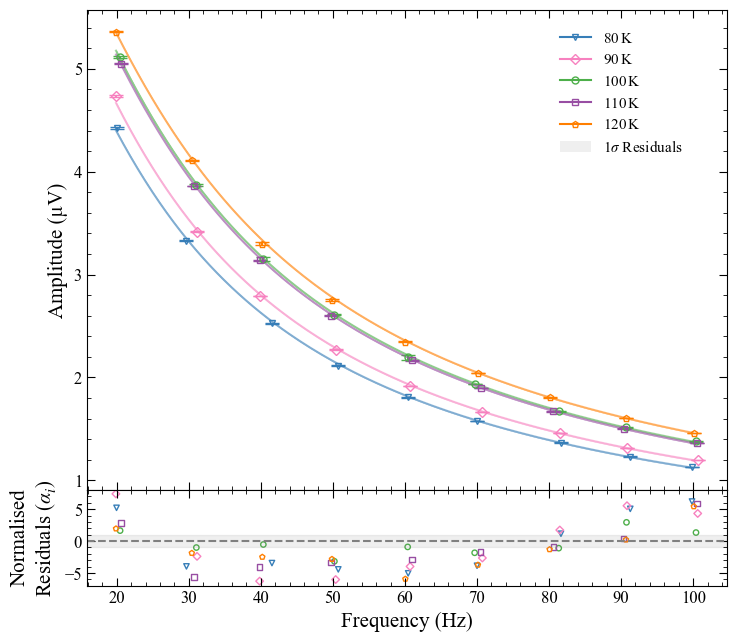

In [269]:
laptop_savepath_FreqInt = r"C:\Users\sebas\Documents\Durham Work\Year 3\Advanced Lab\Report Figures\Freq_Int_plot.png"

scale_factor = 1000

fig = plt.figure(1)

#main plot
ax_main = fig.add_axes([0,0,1,1])

for temp, colour,marker in zip(temperature_list,colours,markers):
    pop = results[temp]["pop"]
    cov = results[temp]["cov"]
    y_fit = Amplitude_model(T_model_range, *pop)
    y_err = model_uncertainty(T_model_range, pop, cov)

    ax_main.errorbar(results[temp]["freq"], results[temp]['int']*scale_factor, yerr = results[temp]['int_err']*scale_factor, linestyle = "none", capsize = 5, markersize = 5, color = colour, label = temp, marker = marker, markerfacecolor = "none")
    ax_main.plot(T_model_range, y_fit*scale_factor, linestyle = "-", color = colour, alpha = 0.5)
    ax_main.fill_between(T_model_range, (y_fit - y_err)*scale_factor, (y_fit + y_err)*scale_factor, color = colour, alpha = 0.25)

residual_band= Patch(
    facecolor="grey",
    alpha=0.12,
    label=r"$1\sigma$ Residuals"
)

legend_elements = [
    Line2D([0], [0],
           color=colours[0],
           marker = markers[0],
           linestyle='-',
           markerfacecolor="none", markersize=5, linewidth=1.5,

           label=r"$80\,\mathrm{K}$"),

    Line2D([0], [0],
           color=colours[1],
           marker = markers[1],
           linestyle='-',
           markerfacecolor="none", markersize=5, linewidth=1.5,
           label=r"$90\,\mathrm{K}$"),
    Line2D([0], [0],
           color=colours[2],
           marker = markers[2],
           linestyle='-',
           markerfacecolor="none", markersize=5, linewidth=1.5,

           label=r"$100\,\mathrm{K}$"),

    Line2D([0], [0],
           color=colours[3],
           marker = markers[3],
           linestyle='-',
           markerfacecolor="none", markersize=5, linewidth=1.5,
           label=r"$110\,\mathrm{K}$"),
    Line2D([0], [0],
           color=colours[4],
           marker = markers[4],
           linestyle='-',
           markerfacecolor="none", markersize=5, linewidth=1.5,

           label=r"$120\,\mathrm{K}$"),
    residual_band
]

ax_main.legend(
    handles = legend_elements,
    loc = "upper right",
    bbox_to_anchor = (0.95, 0.98),
    borderpad = 0.3,
    frameon = False
)

ax_main.set_ylabel("Amplitude (µV)")

#residual plot
ax_res = fig.add_axes([0,-0.2,1,0.2])

for temp, colour,marker in zip(temperature_list,colours,markers):
    pop = results[temp]["pop"]
    cov = results[temp]["cov"]
    xdata = np.array(results[temp]["freq"])
    ydata = np.array(results[temp]["int"])
    yerror = np.array(results[temp]["int_err"])
    residuals = (results[temp]["int"]-Amplitude_model(xdata, *pop))/results[temp]["int_err"]
    ax_res.scatter(xdata,residuals, marker = marker, label = temp,facecolor = "none", color = colour, s = 15)


ax_res.axhline(0, color = "grey", linestyle = "--")
ax_res.axhspan(-1,1, color = "grey", alpha = 0.12)
ax_res.set_xlabel("Frequency (Hz)")
ax_res.set_ylabel(r"Normalised" "\n" r"Residuals ($\alpha_i$)")

# Styling
for ax in [ax_main, ax_res]:
    ax.minorticks_on()
    ax.tick_params(which='major', size=6, direction='in',
                   right=True, top=True)
    ax.tick_params(which='minor', size=3, direction='in',
                   right=True, top=True)

for ax in [ax_main, ax_res]:
    for label in ax.get_xticklabels()+ ax.get_yticklabels():
        label.set_bbox(dict(
            facecolor="white",
            edgecolor="none",
            pad=1.0
        ))

plt.savefig(laptop_savepath_FreqInt, bbox_inches = "tight", dpi = 800)
plt.show()

# Time constant vs Temperature for report

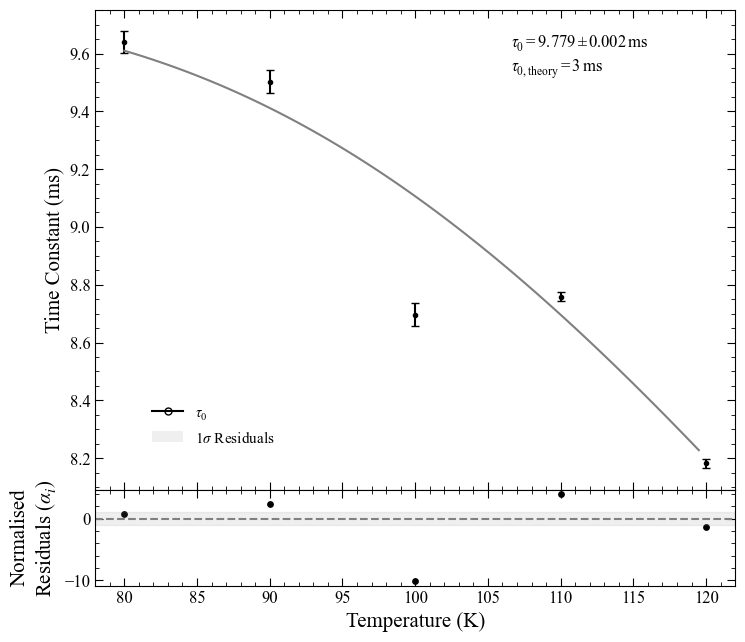

In [270]:
laptop_savepath_timeconst = r"C:\Users\sebas\Documents\Durham Work\Year 3\Advanced Lab\Report Figures\timeconst.png"

fig = plt.figure(1)

ax_main = fig.add_axes([0,0,1,1])

ax_main.errorbar(
    temperatures,
    T_values*scale_factor,
    yerr=T_errors*scale_factor,
    fmt='o',
    markersize =3,
    capsize =3,
    color ="black",
)

ax_main.plot(trange, arrhenius_model(trange, *pop_arr)*scale_factor, color = "grey", linestyle = "-")

ax_main.set_ylabel("Time Constant (ms)")
ax_main.text(
    0.65, 0.95,
    rf"$\tau_0 = {pop_arr[2]*scale_factor:.3f}\, ±\, {np.sqrt(cov_arr[2][2]*scale_factor):.3f}\,\mathrm{{ms}}$",
    transform=ax_main.transAxes,
    fontsize=12,
    verticalalignment='top'
)
ax_main.text(
    0.65, 0.9,
    rf"$\tau_{{0,\mathrm{{theory}}}} = 3\,\mathrm{{ms}}$",
    transform=ax_main.transAxes,
    fontsize=12,
    verticalalignment='top'
)

legend_elements = [
    Line2D([0], [0],
           color="black",
           marker = "o",
           linestyle='-',
           markerfacecolor="none", markersize=5, linewidth=1.5,

           label=r"$\tau_0$"),
    residual_band
]

ax_main.legend(
    handles = legend_elements,
    loc = "upper right",
    bbox_to_anchor = (0.3, 0.2),
    borderpad = 0.3,
    frameon = False
)

ax_res = fig.add_axes([0,-0.2,1,0.2])

residuals = (T_values-arrhenius_model(temperatures, *pop_arr))/T_errors
ax_res.scatter(temperatures, residuals, marker = "o", label = temp, s = 15, color = "black")

ax_res.axhspan(-1, 1, color = "grey", alpha = 0.12)
ax_res.axhline(0, color = "grey", linestyle = "--")
ax_res.set_xlabel("Temperature (K)")
ax_res.set_ylabel(r"Normalised" "\n" r"Residuals ($\alpha_i$)")


# Styling
for ax in [ax_main, ax_res]:
    ax.minorticks_on()
    ax.tick_params(which='major', size=6, direction='in',
                   right=True, top=True)
    ax.tick_params(which='minor', size=3, direction='in',
                   right=True, top=True)

for ax in [ax_main, ax_res]:
    for label in ax.get_xticklabels()+ ax.get_yticklabels():
        label.set_bbox(dict(
            facecolor="white",
            edgecolor="none",
            pad=1.0
        ))

plt.savefig(laptop_savepath_timeconst, bbox_inches = "tight", dpi = 800)
plt.show()